# Prophet Model with Stocks data

**Using the S&P 500 stock prices dataset, build a Prophet model to see how it performs on stock predictions. Filter out a univariate time series, e.g. Google close prices.**

In [1]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('data/sp500sub.csv', index_col='Date', parse_dates=True)

In [3]:
# Univariate time series

goog = df[df['Name'] == 'GOOG'][['Close']].copy()

In [4]:
goog.head()

,Close
Date,
2010-01-04,312.204773
2010-01-05,310.829926
2010-01-06,302.994293
2010-01-07,295.940735
2010-01-08,299.885956


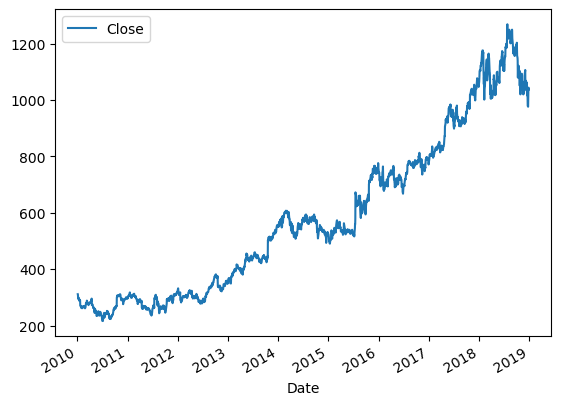

In [5]:
goog.plot();

In [6]:
# Rename Close column and add 'ds' column

goog.columns = ['y']

goog['ds'] = goog.index

In [7]:
goog.head()

,y,ds
Date,,
2010-01-04,312.204773,2010-01-04
2010-01-05,310.829926,2010-01-05
2010-01-06,302.994293,2010-01-06
2010-01-07,295.940735,2010-01-07
2010-01-08,299.885956,2010-01-08


## Build default model

**Do not use entire time series to train the model (last 504 timesteps only, i.e. last couple of years), and specify the forecast horizon as one year into the future.**

**Remember that Prophet is a continuous model and will predict for the non-trading days also.**

08:30:31 - cmdstanpy - INFO - Chain [1] start processing
08:30:31 - cmdstanpy - INFO - Chain [1] done processing


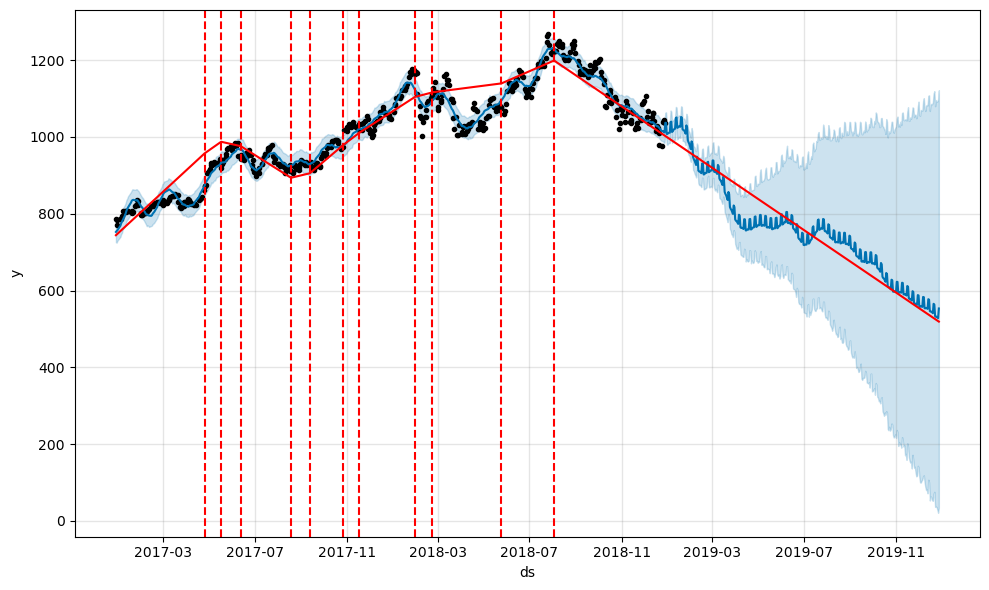

In [8]:
m = Prophet()

m.fit(goog.iloc[-252*2:])

# Generate forecast

future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)

# Plot forecast

fig = m.plot(forecast);

a = add_changepoints_to_plot(fig.gca(), m, forecast)

**Its not that easy to see but it does not seem a great fit. There is some high seasonal frequency in the forecast (see the little blue 'hairs') which is weird for stock data. Daily seasonality does not exist, as the data is daily, but there may be a weekly seasonality component being modeled.**

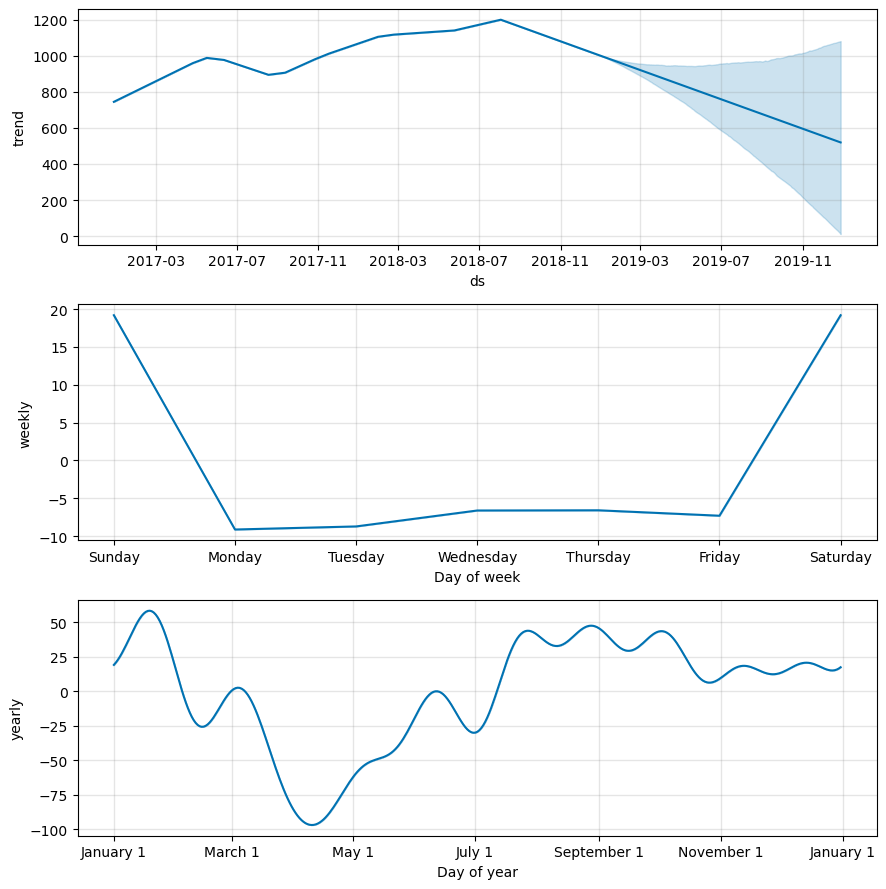

In [9]:
m.plot_components(forecast);

**As expected, there are weekly and yearly seasonality components modeled. The weekly seasonality shows high values at the weekend but low negative values during the week, which makes no sense. The market is not open on the weekend. The yearly seasonality shows a general increase from April to August, but this can basically be handled by the trend component.**

**The trend forecast has increasingly wide prediction intervals which means the model is unsure about the trend.**

**Remember that you only gave the model a couple of years of data!**

## What not to do...

**In some blog articles, it recommends setting the daily seasonality to True for stock data, which makes no sense as you need sub-daily data to model weekly seasonality. However, the results end up being smoother.**

**NOTE: Increase the data size.**

08:43:15 - cmdstanpy - INFO - Chain [1] start processing
08:43:16 - cmdstanpy - INFO - Chain [1] done processing


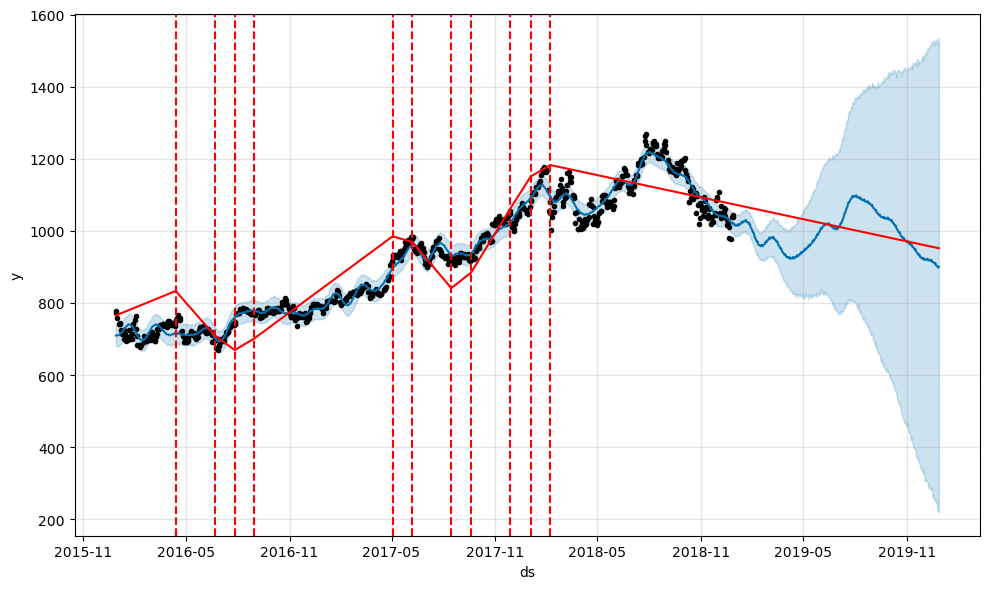

In [10]:
# BAD!!! 

m = Prophet(daily_seasonality=True)

m.fit(goog.iloc[-252*3:])

# Generate forecast

future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)

# Plot forecast

fig = m.plot(forecast);

a = add_changepoints_to_plot(fig.gca(), m, forecast)

**As you see the plot looks more reasonable.**

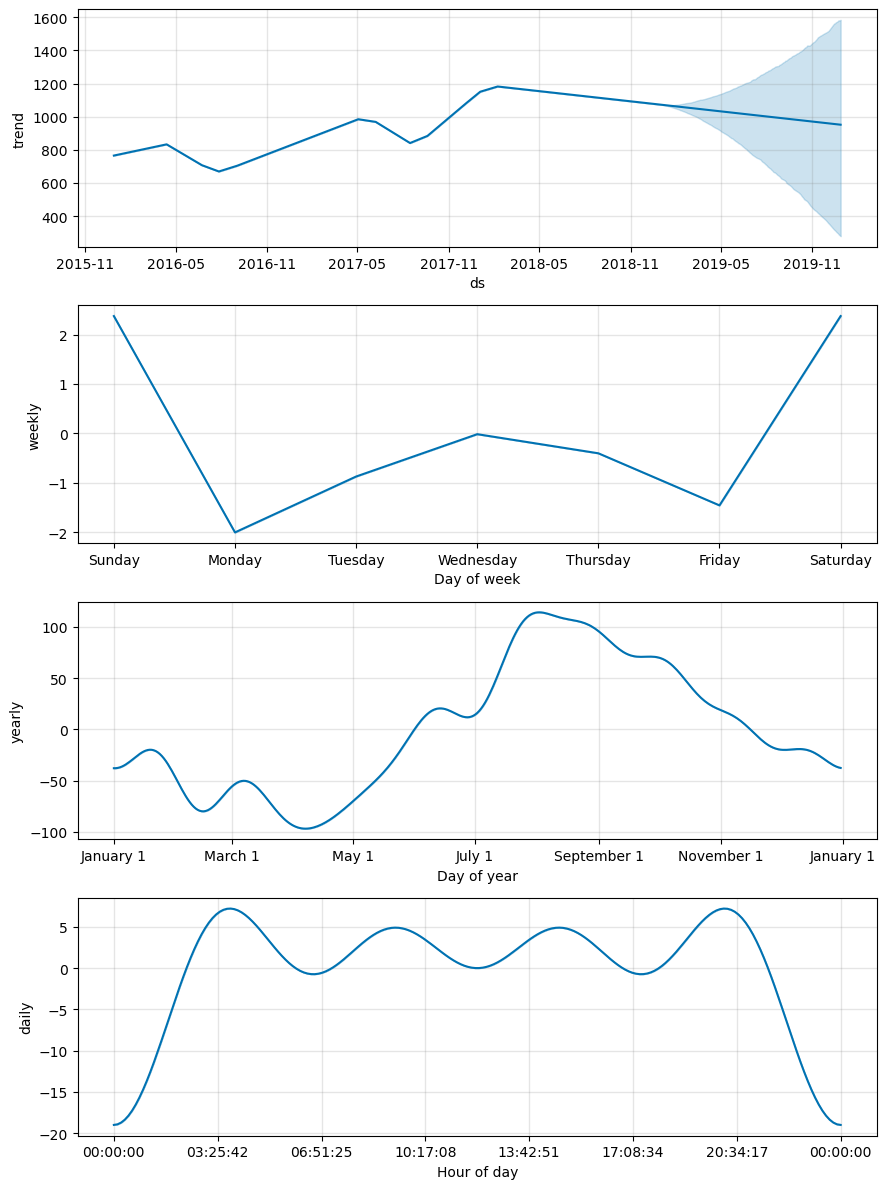

In [11]:
m.plot_components(forecast);

**The daily seasonality component shows high activity during the entire day except for at the start and at the end, but remember what your model is doing should be impossible.**

## What you should do...

**Daily seasonality is just incorrect, and weekly seasonality should also be turned off as it made no sense.** 

08:48:46 - cmdstanpy - INFO - Chain [1] start processing
08:48:46 - cmdstanpy - INFO - Chain [1] done processing


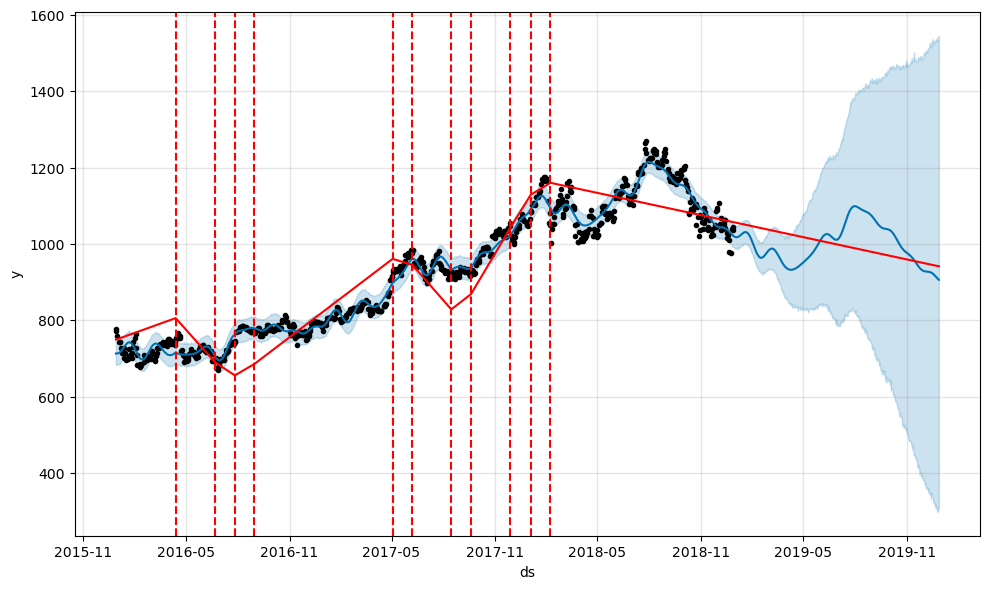

In [12]:
m = Prophet(weekly_seasonality=False)

m.fit(goog.iloc[-252*3:])

# Generate forecast

future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)

# Plot forecast

fig = m.plot(forecast);

a = add_changepoints_to_plot(fig.gca(), m, forecast)

**The plot looks similalr but you can see the trend line and change points are more sensible.**

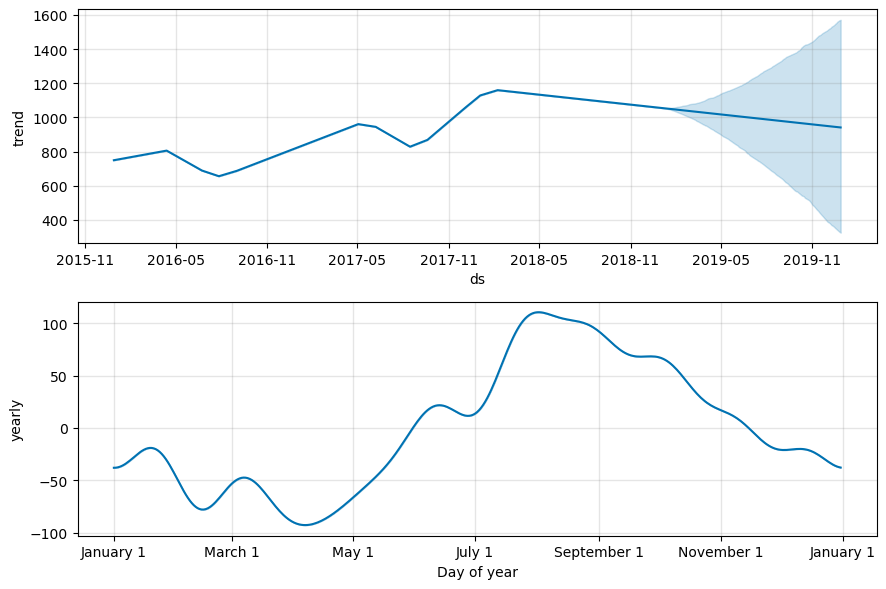

In [13]:
m.plot_components(forecast);

**Similar to be except now you don't have false daily or weekly patterns.**

## Cross-Validation

**You can compare the results from cross-validation with the default model, or baseline forecasts. The best baseline forecast for stock data is predicting the last known true value.**

In [14]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [15]:
m = Prophet(weekly_seasonality=False)

In [16]:
# Last couple of years only

m.fit(goog[-252*2:])

08:52:57 - cmdstanpy - INFO - Chain [1] start processing
08:52:57 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# Try period=15, horizon=30
# Try period=5, horizon=5

df_cv = cross_validation(m, 
                         initial='366 days', 
                         period='30 days', 
                         horizon='60 days')

  0%|          | 0/11 [00:00<?, ?it/s]

08:53:50 - cmdstanpy - INFO - Chain [1] start processing
08:53:50 - cmdstanpy - INFO - Chain [1] done processing
08:53:51 - cmdstanpy - INFO - Chain [1] start processing
08:53:51 - cmdstanpy - INFO - Chain [1] done processing
08:53:51 - cmdstanpy - INFO - Chain [1] start processing
08:53:51 - cmdstanpy - INFO - Chain [1] done processing
08:53:51 - cmdstanpy - INFO - Chain [1] start processing
08:53:51 - cmdstanpy - INFO - Chain [1] done processing
08:53:51 - cmdstanpy - INFO - Chain [1] start processing
08:53:51 - cmdstanpy - INFO - Chain [1] done processing
08:53:52 - cmdstanpy - INFO - Chain [1] start processing
08:53:52 - cmdstanpy - INFO - Chain [1] done processing
08:53:52 - cmdstanpy - INFO - Chain [1] start processing
08:53:52 - cmdstanpy - INFO - Chain [1] done processing
08:53:52 - cmdstanpy - INFO - Chain [1] start processing
08:53:52 - cmdstanpy - INFO - Chain [1] done processing
08:53:53 - cmdstanpy - INFO - Chain [1] start processing
08:53:53 - cmdstanpy - INFO - Chain [1]

In [18]:
df_cv.head(20)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-01-03,1065.833887,1052.620475,1079.611611,1082.479980,2018-01-02
1,2018-01-04,1066.916090,1053.729684,1080.918185,1086.400024,2018-01-02
2,2018-01-05,1068.098758,1053.866436,1081.828710,1102.229980,2018-01-02
3,2018-01-08,1072.191161,1058.936666,1086.481504,1106.939941,2018-01-02
4,2018-01-09,1073.697942,1060.570164,1087.497968,1106.260010,2018-01-02
5,2018-01-10,1075.248186,1062.108874,1089.308025,1102.609985,2018-01-02
6,2018-01-11,1076.821150,1063.430498,1090.762456,1105.520020,2018-01-02
7,2018-01-12,1078.394267,1064.812676,1093.251234,1122.260010,2018-01-02
8,2018-01-16,1084.213449,1069.466101,1098.426193,1121.760010,2018-01-02
9,2018-01-17,1085.435779,1072.288101,1099.020897,1131.979980,2018-01-02


In [19]:
# Always the same 6 columns

df_cv.shape

(457, 6)

In [20]:
# Use cross-validation results to make naive forecast

naive = df_cv[['ds', 'yhat', 'y', 'cutoff']].copy()

In [21]:
# Replace 'yhat' column with naive forecast

naive_storage = np.zeros(naive.shape[0])

one_day = pd.Timedelta(1, 'day')

for i, row in naive.iterrows():
    cutoff = row['cutoff']
    print(cutoff)
    
    # Must find last cutoff that actually exists in df - every forecast comes from cutoff date
    while cutoff not in goog.index:
        cutoff = cutoff - one_day
        
    naive_storage[i] = goog.loc[cutoff]['y']


naive['yhat'] = naive_storage

2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-01-02 00:00:00
2018-02-01 00:00:00
2018-02-01 00:00:00
2018-02-01 00:00:00
2018-02-01 00:00:00
2018-02-01 00:00:00
2018-02-01 00:00:00
2018-02-01 00:00:00
2018-02-01 00:00:00
2018-02-01 00:00:00


In [22]:
# Compute model forecast average SMAPE score

pm = performance_metrics(df_cv)

pm['smape'].mean()

0.08447298478179466

In [23]:
# Compute naive model forecast average SMAPE score

naive_metrics = performance_metrics(naive)

naive_metrics['smape'].mean()

0.05863868224580872

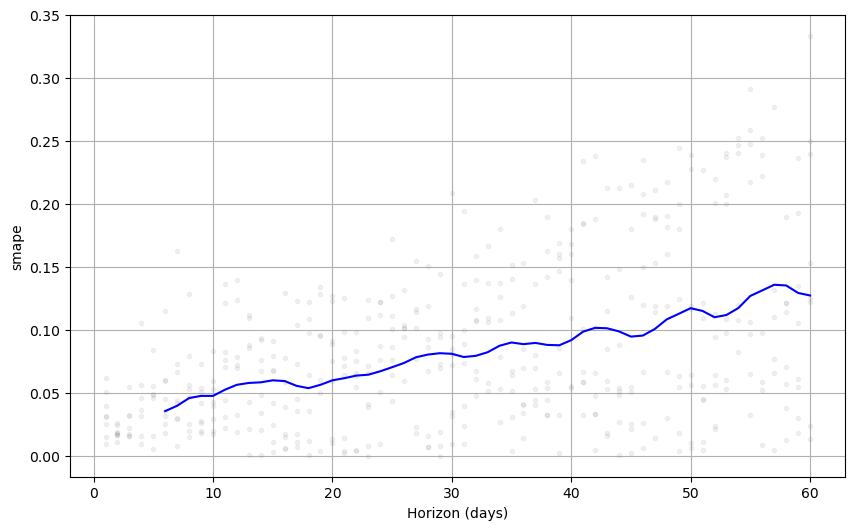

In [24]:
# Plot model SMAPE scores

plot_cross_validation_metric(df_cv, metric='smape');

**So the average naive forecast score is better (lower is better), and we can see that the model SMAPE score is steadily increasing as the forecast horizon gets longer, so the model does not outperform the naive forecasting method, even after cross-validation.**

## Cross-Validation with Log-Transformed data

**What if you built Prophet model with log-transformed stock prices? Compare results to naive forecasting.**

In [25]:
log_goog = goog.copy()

log_goog['y'] = np.log(goog['y'])

In [26]:
m = Prophet(weekly_seasonality=False)

m.fit(log_goog[-252*2:])

df_cv = cross_validation(m, 
                         initial='365 days', 
                         period='30 days', 
                         horizon='60 days')

pm = performance_metrics(df_cv)

pm['smape'].mean()

09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/11 [00:00<?, ?it/s]

09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] done processing
09:09:38 - cmdstanpy - INFO - Chain [1] start processing
09:09:38 - cmdstanpy - INFO - Chain [1] done processing
09:09:38 - cmdstanpy - INFO - Chain [1] start processing
09:09:38 - cmdstanpy - INFO - Chain [1] done processing
09:09:38 - cmdstanpy - INFO - Chain [1] start processing
09:09:38 - cmdstanpy - INFO - Chain [1] done processing
09:09:39 - cmdstanpy - INFO - Chain [1] start processing
09:09:39 - cmdstanpy - INFO - Chain [1] done processing
09:09:39 - cmdstanpy - INFO - Chain [1] start processing
09:09:39 - cmdstanpy - INFO - Chain [1] done processing
09:09:39 - cmdstanpy - INFO - Chain [1] start processing
09:09:40 - cmdstanpy - INFO - Chain [1] done processing
09:09:40 - cmdstanpy - INFO - Chain [1] start processing
09:09:40 - cmdstanpy - INFO - Chain [1] done processing
09:09:40 - cmdstanpy - INFO - Chain [1] start processing
09:09:41 - cmdstanpy - INFO - Chain [1]

0.014518189285076689

**So far, the accuracy seems to have improved greatly. However, you need to recreate the naive forecasting from the cross-validation results just generated.**

In [28]:
naive = df_cv[['ds', 'yhat', 'y', 'cutoff']].copy()

naive_storage = np.zeros(naive.shape[0])

for i, row in naive.iterrows():
    cutoff = row['cutoff']
    #print(cutoff)
    
    # Must find last cutoff that actually exists in df
    while cutoff not in goog.index:
        cutoff = cutoff - pd.Timedelta(1, 'day')
        
    naive_storage[i] = log_goog.loc[cutoff]['y']


naive['yhat'] = naive_storage

naive_metrics = performance_metrics(naive)

naive_metrics['smape'].mean()

0.008361150811971313

**And still the naive forecasting outperforms the model.**

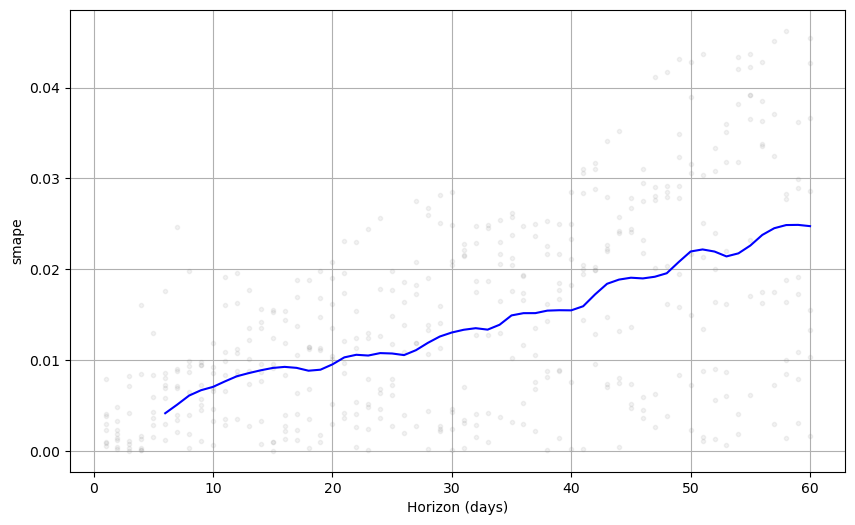

In [29]:
plot_cross_validation_metric(df_cv, metric='smape');

**The model SMAPE score seems to increase at a faster rate when using log-transformed data, i.e. forecast error increases over time.**

**Remember that stock data is very difficult to predict, and Prophet is no better than any other model, no matter what any article says.**